In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import beta

import sys
sys.path.append('../')

import Modules.Loaders.DataFormatter as DF
from utils import get_case_name, AIC_OLS, RSS

***
### Load data

In [12]:
# create data matrix of compartments STEAYDQRF
# choose and get data
path = '../Data/covasim_data/drums_data/'
population = 200000
test_prob = 0.1
trace_prob = 0.3
keep_d = True
retrain = False
dynamic = True
chi_type = 'constant'

case_name = get_case_name(population, test_prob, trace_prob, keep_d, dynamic=dynamic, chi_type=chi_type)
params = DF.load_covasim_data(path, population, test_prob, trace_prob, keep_d, case_name, plot=False)

In [13]:
data = params['data']
data = (data / params['population']).to_numpy()
N = len(data)
t_max = N - 1
t = np.arange(N)
params.pop('data')

,S,T,E,A,Y,D,Q,R,F
0,199600,0,400,0,0,0,0,0,0
1,199599,0,400,0,1,0,0,0,0
2,199593,0,389,5,13,0,0,0,0
3,199551,8,313,38,88,2,0,0,0
4,199438,42,290,69,150,11,0,0,0
...,...,...,...,...,...,...,...,...,...
178,110967,3729,1001,726,886,796,59,81436,400
179,110944,3607,953,723,867,790,60,81654,402
180,110865,3536,914,732,827,793,65,81865,403
181,110773,3478,910,711,842,763,59,82059,405


Let us consider a collection of agents that are either blue (`blue=1`), or not blue (`blue=0`). Whether or not an agent is blue is random, however, the probability of them becoming blue or not is dependent on other things around it.

We may not know exactly how or why agents become `blue=1`, but if we are to create a simulation of these agents, we would like to be able to model the behavior of this `blue` attribute over the course of the simulation. In some cases, `blue` may affect other things as well.

### Problem: Agents may have attributes/behaviors that are stochastic AND dynamic. How do we model this dynamic stochastic behavior?
***

For this case, we would like to take advantage of the logistic function in order to model the probability of being blue or not. Let $X=(X_1, \ldots, X_p)$ be the $p$ predictors of a single random sample. The logistic function is defined as 
$$p(X) = \frac{e^{\beta^TX}}{1 + e^{\beta^T X}}$$
which can be expressed as $$\frac{p(X)}{1 - p(X)} = e^{\beta^T X}$$
The left hand side is known as the ***odds***. Taking the logarithm of both sides, we obtain
$$\log\Big( \frac{p(X)}{1 - p(X)}  \Big) = \beta^T X$$
The left hand side is called the ***log odds*** or ***logit***.

Unlike a classic supervised machine learning problem using logistic regression, we aren't trying to estimate $\beta$ using observed data. What we would like instead is to model a behavior of our agents dynamically using states of the model. In this case, we would be modifying the probability of an agent acting on a behavior dependent on other features and states of the model.

Consider a state of the model $D$. Let's assume that $D$ is an unknown nonlinear function but all of its values lie in the interval $[0, 0.5]$. Let's assume that $\beta$ is just a fixed vector.

Consider, 
$$p(Z) = \frac{e^{\beta_0 + \beta_1 D(t) - \beta_2 t}}{1 + e^{\beta_0 + \beta_1 D(t) - \beta_2 t}}$$
So, fixing all other things, as $D(t)$ increases, so does the $p(Z)$. And fixing all other things, as $t$ increases, then $p(Z)$ decreases.

In [31]:
def D_func(t, D_lb, D_ub):
    res_all = D_ub * np.ones(200)
    t_max = max(t)
    t_scaled = t / t_max

    # use pdf of beta distribution
    a, b = 3, 3
    res = beta.pdf(t_scaled, a, b, loc=0, scale=1)
    max_val = np.max(res)
    res = res * D_ub / max_val
    res_all[:80] = res[:80]
    res_all[-80:] = res[-80:]
    return res_all
    
t = np.arange(0, 200)
D_array = D_func(t, 0, 0.5)

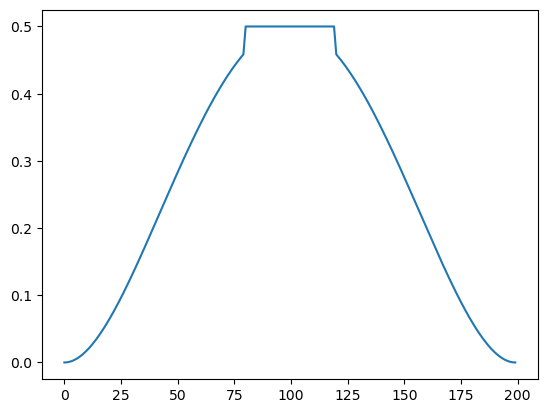

In [32]:
plt.plot(t, D_array)

In [33]:
beta0 = 1
beta1 = 1
beta2 = 1

def prob_z(x, betas, func):
    result = np.exp(betas[0] + betas[1] * D_func(t, 0, 0.5) - betas[2] * t)
    result = (result) / (1 + result)
    return result

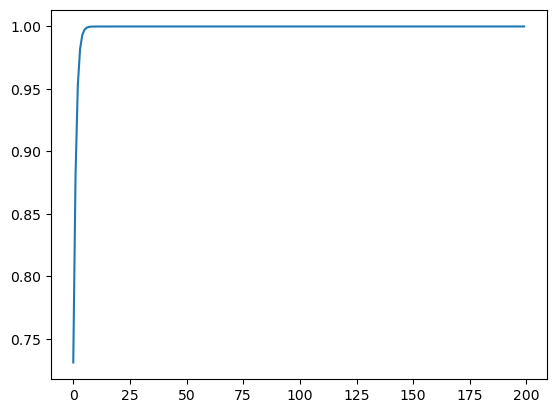

In [34]:
plt.plot(t, prob_z(t, [beta0, beta1, beta2], D_func))